In [ ]:
# Setup
# importing necessary packages for data processing, image manipulation, and deep learning
from __future__ import print_function, division

import os  # operating system interactions
import cv2  # computer vision algorithms and image processing
import time  # time-related functions
import copy  # creating copies of objects
import argparse  # building command-line interfaces
import warnings  # controlling warnings
import numpy as np  # array manipulation and mathematical functions
import pandas as pd  # data manipulation and analysis
from tqdm import tqdm  # progress bar functionality
from functools import partial  # partial function application
#import matplotlib.pyplot as plt  # plotting
from collections import namedtuple  # creating named tuples

import torch  # core library for tensor computation and deep neural networks
import torchvision  # working with image and video data
import torch.nn as nn  # neural network modules and loss functions
from PIL import Image  # image manipulation
from torch import Tensor  # tensor representation
import torch.optim as optim  # optimization algorithms
import torch.nn.functional as F  # functional operations in neural networks
from torchvision import datasets  # standard datasets
import torchvision.transforms as T  # image transformations
from torchvision import transforms  # image transformations
from torchvision.models import ResNet, resnet18  # pre-defined ResNet models
from torch.utils.data import DataLoader  # loading data in PyTorch
from torchvision.transforms import ToTensor  # converting PIL images to tensors
from torch.utils.data.dataset import Dataset  # creating custom datasets
from torch.hub import load_state_dict_from_url  # model loading
from typing import Any, Callable, List, Optional, Type, Union, Tuple  # type hints for code understanding
import math

In [ ]:
print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


In [ ]:
# Helper Functions

# conv function

class gen(nn.Module):
    def __init__(self):
        super(gen, self).__init__()
        self.conv1d = nn.Conv1d(1, 100, kernel_size=201, stride=101, padding=0)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(800, 64)
        self.relu = nn.ReLU()

        self.dense = nn.Linear(949, 256)
        self.dense2 = nn.Linear(256, 64)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        #x = x.unsqueeze(1)
        #print("SHAPE X:",x.shape)
        out = self.dense(x)
        out = self.relu(out)
        # print("SHAPE cov out:",out.shape)
        #out = self.flatten(out)
        # print("SHAPE flatten out:",out.shape)
        out = self.dense2(out)
        out = self.relu(out)

        #out = self.dropout(out)
        return out


# module to help prep the data for determining fish
class FishDataset(Dataset):
    def __init__(self, csv_path, dataset_dir, spectra_dir, transform=None):
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)

        # Get the directory dataset images
        self.dataset_dir = dataset_dir

        # Get the transform methods
        self.transforms = transform

        self.spectra_data = np.asarray(self.data_info.iloc[:, 13:])

        # Image Name
        # self.image_name = []
        # for index, row in self.data_info.iterrows():
        #     year = row['year']
        #     vessel = row['vessel']
        #     my_id = row['id']
        #     try:
        #         image_name = str(int(year)) + '_' + str(int(float(vessel))) + '_' + str(int(my_id)) + '.jpg'
        #     except:
        #         image_name = str(int(year)) + '_' + str(vessel) + '_' + str(int(my_id)) + '.jpg'
        #     self.image_name.append(image_name)
        self.image_name = np.asarray(self.data_info.iloc[:, 1])
        self.image_folder = np.asarray(self.data_info.iloc[:, 2])

        # Otolith length
        self.length = np.asarray(self.data_info.iloc[:, 6])

        # Otolith weight
        self.wt = np.asarray(self.data_info.iloc[:, 8])

        # Fish Age
        self.age = np.asarray(self.data_info.iloc[:, 9])

        # Lat
        self.lat = np.asarray(self.data_info.iloc[:, 11])

        # Long
        self.long = np.asarray(self.data_info.iloc[:, 12])

        # Sex
        self.sex = np.asarray(self.data_info.iloc[:, 7])

        # Spectra image
        #self.spectra = np.asarray(self.data_info.iloc[:, 5])

        # Readability
        self.read = np.asarray(self.data_info.iloc[:, 10])

        # Gear Depth
        #self.g_depth = np.asarray(self.data_info.iloc[:, 11])

        # Bottom Depth
        #self.b_depth = np.asarray(self.data_info.iloc[:, 12])

        # month
        self.month = np.asarray(self.data_info.iloc[:, 3])
        self.day = np.asarray(self.data_info.iloc[:, 4])
        self.year = np.asarray(self.data_info.iloc[:, 5])


    def __len__(self):
        return len(self.data_info.index)

    def __getitem__(self, index):
        img_path = os.path.join(self.dataset_dir, str(self.image_folder[index]), str(self.image_name[index].split(".")[0].strip() + ".jpg"))
        image = Image.open(img_path)
        # wt_l_m = torch.tensor(
        #     [(self.wt[index] - 163) / (82), (self.length[index] - 211) / (35.5)])
        # if(math.isnan(self.g_depth[index])):
        #     self.g_depth[index] = self.b_depth[index]
        wt_l_m = torch.tensor(
            [(self.wt[index]-0.9530)/0.5686, (self.length[index]-515.5979)/134.68, self.lat[index], self.long[index], (self.sex[index]-2.929)/0.953,
            (self.month[index]-7.223)/2.7332, (self.day[index]-15.8901)/8.483, (self.year[index]-2021.32)/0.73])
        if (self.age[index] < 17):
            label_age = int(self.age[index]) - 1
        else:
            label_age = 16

        readability = self.read[index]

        spectra_data = self.spectra_data[index]

        if self.transforms:
            image = self.transforms(image)

        return (image, wt_l_m), label_age, spectra_data, readability
# Modified Resnet Backbone

class SoftCrossEntropy(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
    def forward(self, logits, targets, readability):
        soft = torch.tensor(soft_possibility[targets.cpu().detach().numpy()], dtype = torch.float32).type(torch.DoubleTensor).to("cuda")
#         soft = F.one_hot(targets, num_classes = 17).type(torch.DoubleTensor).to("cuda")
#         for i in range(logits.shape[0]):

#             if(readability[i] == 1):
#                 soft[i] = soft[i]*0.95

#                 if(targets[i]-1 >= 0):
#                     soft[i][targets[i]-1] = 0.025
#                 if(targets[i]+1 <17):
#                     soft[i][targets[i]+1] = 0.025
#             elif(readability[i] == 2):
#                 soft[i] = soft[i]*0.8
#                 if(targets[i]-1 >= 0):
#                     soft[i][targets[i]-1] = 0.1
#                 if(targets[i]+1 <17):
#                     soft[i][targets[i]+1] = 0.1
#             else:
#                 soft[i] = soft[i]*0.8
#                 if(targets[i]-1 >= 0):
#                     soft[i][targets[i]-1] = 0.09
#                 if(targets[i]-2 >= 0):
#                     soft[i][targets[i]-2] = 0.01
#                 if(targets[i]+1 <17):
#                     soft[i][targets[i]+1] = 0.09
#                 if(targets[i]+2 <17):
#                     soft[i][targets[i]+2] = 0.01

#         soft = F.normalize(soft, p=1, dim = 1)
        return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * soft, dim=1))

# function creating a 3x3 convolutional layer
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """
    Function to create a 3x3 convolutional layer with padding.

    Args:
    - in_planes (int): Number of input channels.
    - out_planes (int): Number of output channels.
    - stride (int): Stride value for the convolution (default: 1).
    - groups (int): Number of groups for grouped convolution (default: 1).
    - dilation (int): Dilation rate for the convolution (default: 1).

    Returns:
    - conv_layer (nn.Conv2d): The created 3x3 convolutional layer.
    """
    # Create a 3x3 convolutional layer with the specified parameters
    conv_layer = nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

    return conv_layer

# function creating a 1x1 convolutional layer
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """
    Function to create a 1x1 convolutional layer.

    Args:
    - in_planes (int): Number of input channels.
    - out_planes (int): Number of output channels.
    - stride (int): Stride value for the convolution (default: 1).

    Returns:
    - conv_layer (nn.Conv2d): The created 1x1 convolutional layer.
    """
    # Create a 1x1 convolutional layer with the specified parameters
    conv_layer = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

    return conv_layer

# module to define a BasicBlock residual block for the resnet model
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        """
        Basic residual block implementation used in ResNet.

        Args:
        - inplanes (int): Number of input channels.
        - planes (int): Number of output channels.
        - stride (int): Stride value for the convolutional layers (default: 1).
        - downsample (nn.Module, optional): Downsample module (default: None).
        - groups (int): Number of groups for grouped convolution (default: 1).
        - base_width (int): Base width for grouped convolution (default: 64).
        - dilation (int): Dilation rate for dilated convolution (default: 1).
        - norm_layer (Callable[..., nn.Module], optional): Normalization layer (default: nn.BatchNorm2d).
        """
        super(BasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")

        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)  # 3x3 convolutional layer
        self.bn1 = norm_layer(planes)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function
        self.conv2 = conv3x3(planes, planes)  # 3x3 convolutional layer
        self.bn2 = norm_layer(planes)  # Batch normalization
        self.downsample = downsample  # Downsample module
        self.stride = stride  # Stride value for the convolutional layers

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the BasicBlock.

        Args:
        - x (Tensor): Input tensor.

        Returns:
        - out (Tensor): Output tensor.
        """
        identity = x

        out = self.conv1(x)  # First convolutional layer
        out = self.bn1(out)  # Batch normalization
        out = self.relu(out)  # ReLU activation

        out = self.conv2(out)  # Second convolutional layer
        out = self.bn2(out)  # Batch normalization

        if self.downsample is not None:
            identity = self.downsample(x)  # Downsample the input if needed

        out += identity  # Add the residual connection
        out = self.relu(out)  # ReLU activation

        return out


# module to define a Bottleneck residual block for the resnet model
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution (self.conv2)
    # while the original implementation places the stride at the first 1x1 convolution (self.conv1)
    # according to "Deep residual learning for image recognition" (https://arxiv.org/abs/1512.03385).
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        """
        Bottleneck residual block implementation used in ResNet.

        Args:
        - inplanes (int): Number of input channels.
        - planes (int): Number of output channels.
        - stride (int): Stride value for the convolutional layers (default: 1).
        - downsample (nn.Module, optional): Downsample module (default: None).
        - groups (int): Number of groups for grouped convolution (default: 1).
        - base_width (int): Base width for grouped convolution (default: 64).
        - dilation (int): Dilation rate for dilated convolution (default: 1).
        - norm_layer (Callable[..., nn.Module], optional): Normalization layer (default: nn.BatchNorm2d).
        """
        super(Bottleneck, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        width = int(planes * (base_width / 64.0)) * groups

        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)  # 1x1 convolutional layer
        self.bn1 = norm_layer(width)  # Batch normalization
        self.conv2 = conv3x3(width, width, stride, groups, dilation)  # 3x3 convolutional layer
        self.bn2 = norm_layer(width)  # Batch normalization
        self.conv3 = conv1x1(width, planes * self.expansion)  # 1x1 convolutional layer
        self.bn3 = norm_layer(planes * self.expansion)  # Batch normalization
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function
        self.downsample = downsample  # Downsample module
        self.stride = stride  # Stride value for the convolutional layers

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the Bottleneck.

        Args:
        - x (Tensor): Input tensor.

        Returns:
        - out (Tensor): Output tensor.
        """
        identity = x

        out = self.conv1(x)  # First 1x1 convolutional layer
        out = self.bn1(out)  # Batch normalization
        out = self.relu(out)  # ReLU activation

        out = self.conv2(out)  # 3x3 convolutional layer
        out = self.bn2(out)  # Batch normalization
        out = self.relu(out)  # ReLU activation

        out = self.conv3(out)  # Second 1x1 convolutional layer
        out = self.bn3(out)  # Batch normalization

        if self.downsample is not None:
            identity = self.downsample(x)  # Downsample the input

        out += identity  # Residual connection
        out = self.relu(out)  # ReLU activation

        return out

# module defining modified RESNET backbone

class ResNet(nn.Module):
    def __init__(
            self,
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            num_classes: int = 17,
            img_size: int = 64,
            metadata_size: int = 32,
            spectral_size: int = 32,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None,
        ) -> None:
        super(ResNet, self).__init__()

        # If norm_layer is not provided, default to nn.BatchNorm2d
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        # Check if replace_stride_with_dilation is provided
        if replace_stride_with_dilation is None:
            # If not provided, set it to a default value of [False, False, False]
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )

        self.groups = groups
        self.base_width = width_per_group

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers (layer1, layer2, layer3, layer4)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])

        # Adaptive average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_meta = nn.Linear(8, metadata_size)
        self.fc_img = nn.Linear(512 * block.expansion, img_size)
        # self.fc_spectra = nn.Linear(921, spectral_size)
        self.gen = gen()
        self.fc_combined = nn.Linear(metadata_size + spectral_size +img_size,num_classes)

        self.dropout = nn.Dropout(p=0.5)
        self.soft = nn.Softmax(dim = 1)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        # Adjust dilation and stride if dilate is True
        if dilate:
            self.dilation *= stride
            stride = 1

        # Create downsample layer if stride != 1 or number of input channels is different from output channels
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # Add the first block of the layer with potential downsampling
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion

        # Add the rest of the blocks in the layer
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor, metadata: Tensor, spectral_data: Tensor) -> Tensor:
        # See note [TorchScript super()]
        spectral_data_trans = self.gen(spectral_data)
        # print("gen out", spectral_data_trans.shape)
        metadata = F.relu(self.fc_meta(metadata))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # First residual layer
        x = self.layer2(x)  # Second residual layer
        x = self.layer3(x)  # Third residual layer
        x = self.layer4(x)  # Fourth residual layer

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_img(x)

        combined_features = torch.cat((x, metadata, spectral_data_trans), dim=1)
        combined_features = self.dropout(combined_features)
        x = self.fc_combined(combined_features)
        return x

    def forward(self, x: Tensor, metadata: Tensor, spectral_data: Tensor) -> Tensor:
        """
        Forward pass of the ResNet model.

        Args:
            x (Tensor): Input image tensor.
            metadata (Tensor): Metadata tensor.
            spectral_data (Tensor): Spectral data tensor.

        Returns:
            Tensor: Output tensor.
        """
        return self._forward_impl(x, metadata, spectral_data)


# function to train the revised Resnet model
def resnet_new(block: Type[Union[BasicBlock, Bottleneck]],
               layers: List[int],
               pretrained: bool = False,
               num_classes: int = 17,
               metadata_size: int = 32,
               img_size: int = 64,
               spectral_size: int = 32,
               progress: bool = True,
               **kwargs: Any) -> ResNet:
    """
    Create a new ResNet model.

    Args:
        block (Type[Union[BasicBlock, Bottleneck]]): Type of the residual block (BasicBlock or Bottleneck).
        layers (List[int]): List specifying the number of blocks in each layer of the network.
        pretrained (bool): Whether to load a pretrained ResNet model. Default is False.
        num_classes (int): Number of output classes. Default is 17.
        metadata_size (int): Size of the metadata input. Default is 32.
        img_size (int): Size of the image input. Default is 64.
        spectral_size (int): Size of the spectral data input. Default is 32.
        progress (bool): Whether to display a progress bar when downloading pretrained weights. Default is True.
        **kwargs (Any): Additional keyword arguments to pass to the ResNet constructor.

    Returns:
        ResNet: ResNet model.
    """
    if pretrained:
        # Load a pretrained ResNet18 model
        model = resnet.resnet18(pretrained=True, progress=progress)
        # Update the final fully connected layer for the desired number of classes
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model

    # Update the kwargs dictionary with the specified parameters
    kwargs['metadata_size'] = metadata_size
    kwargs['img_size'] = img_size
    kwargs['spectral_size'] = spectral_size
    kwargs['block'] = block
    kwargs['layers'] = layers

    # Create a new ResNet model with modified parameters
    model = ResNet(**kwargs)
    return model

# function to train or evaluate the model
def train_model_classification(model,
                               dataloaders,
                               criterion,
                               optimizer,
                               scheduler,
                               device,
                               num_epochs=25
):
    """
    Train a classification model.

    Args:
        model (nn.Module): The model to train.
        dataloaders (dict): A dictionary containing the data loaders for training, validation, and testing.
        criterion: The loss function used for training.
        optimizer: The optimizer used for training.
        scheduler: The learning rate scheduler.
        device: The device on which to perform the training.
        num_epochs (int): The number of training epochs. Default is 25.

    Returns:
        list: A list containing the trained model, loss history, accuracy history, result (running_res), training result (training_res), and confusion matrix (cm).
    """

    loss_list = []  # List to store the loss history
    acc_list = []  # List to store the accuracy history
    res = []  # List to store the running_res result
    training_res = []  # List to store the training result

    since = time.time()  # Record the starting time

    best_model_wts = copy.deepcopy(model.state_dict())  # Create a deep copy of the model's weights
    best_acc = 0  # Variable to store the best accuracy
    best_train_acc = 0  # Variable to store the best training accuracy

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0  # Variable to accumulate the running loss
            running_corrects = 0  # Variable to accumulate the number of correct predictions
            running_corrects2 = 0  # Variable to accumulate the number of top-2 correct predictions
            count_3 = 0  # Variable to count the occurrences of class 3

            # Iterate over data.
            print("Expecting data")

            running_corr = np.zeros(17)  # Array to accumulate the number of correct predictions per class
            running_total = np.zeros(17)  # Array to accumulate the total number of instances per class
            running_corr2 = np.zeros(17)  # Array to accumulate the number of top-2 correct predictions per class
            cm = np.zeros((17, 17))  # Confusion matrix

            # Iterate over the data loader
            for (inputs, meta_data) , labels, spectra_data, readability in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                meta_data = meta_data.to(device).float()
                spectra_data = spectra_data.to(device).float()

                #targets = torch.tensor(np.eye(17, dtype='uint8')[labels], dtype = torch.int).to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs, metadata=meta_data, spectral_data=spectra_data)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs, labels)
                    #loss = criterion(outputs, labels, num_per_cls)

                    _, preds = torch.max(outputs, 1)  # Get the predicted labels

                    # Backward pass and optimization only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                preds2 = torch.topk(outputs, 2, 1)[1]  # Get the top-2 predicted labels

                # Iterate over each instance in the batch
                for i in range(0, len(preds)):
                    if labels.data[i].cpu().detach().numpy() in preds2.cpu().detach().numpy()[i]:
                        running_corr2[labels.data[i].cpu().detach().numpy()] += 1
                        running_corrects2 += 1
                    if labels.data[i].cpu().detach().numpy() == 3:
                        count_3 += 1

                    if preds[i] == labels.data[i]:
                        running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
                    cm[preds[i], labels.data[i]] += 1
                    running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0
            print(running_total)  # Print the running total for each class

            scheduler.step()  # Update the learning rate scheduler

            epoch_loss = running_loss / len(dataloaders[phase].dataset)  # Calculate the average epoch loss
            epoch_acc = 100.0 * running_corrects / len(dataloaders[phase].dataset)  # Calculate the average epoch accuracy
            top2_acc = 100.0 * running_corrects2 / len(dataloaders[phase].dataset)  # Calculate the top-2 average epoch accuracy
            running_res = [100.0 * i / max(1, j) for i, j in zip(running_corr, running_total)]  # Calculate the class-wise accuracy
            running_res2 = [100.0 * i / max(1, j) for i, j in zip(running_corr2, running_total)]  # Calculate the class-wise top-2 accuracy

            #np.save('confusion_matrix.npy', np.asarray(cm))  # Save the confusion matrix as a numpy array

            # Print the loss and accuracies for the current phase
            print("{} Loss: {:.4f} Average Accuracy: {:.4f} Average Accuracy2: {:.4f}".format(phase, epoch_loss, epoch_acc, top2_acc))

            # Deep copy the model if it achieves the best accuracy in training or validation phase
            if phase == "train" and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                training_res = running_res.copy()

            if phase == "val" and top2_acc >= best_acc:
                best_acc = top2_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                res = running_res.copy()
                np.save('confusion_matrix.npy', np.asarray(cm))
                torch.save(model.state_dict(), 'best_model_all.pth')

            if phase == "val":
                loss_list.append(epoch_loss)
                acc_list.append(epoch_acc.cpu().clone().numpy())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best Accuracy: {:4f}".format(best_acc))

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    return [model, loss_list, acc_list, res, training_res], cm

In [ ]:
# Set the data directories and file paths
data_dir = "/kaggle/input/red-snapper/snapper"
train_csv_path = "/kaggle/input/red-snapper/snapper/train_dataset.csv"
test_csv_path = "/kaggle/input/red-snapper/snapper/test_dataset.csv"
val_csv_path = "/kaggle/input/red-snapper/snapper/validation_dataset.csv"
img_dir = "/kaggle/input/red-snapper/snapper/cropped_images"
spectra_dir = data_dir

# Define data transforms for training and testing
data_transforms_train = transforms.Compose(
    [
        transforms.Resize(312),  # Resize the image to a specific size
        transforms.RandomCrop(299),  # Randomly crop the image
        transforms.RandomHorizontalFlip(),  # Perform horizontal flipping
        transforms.RandomRotation(degrees=20),  # Perform random rotation
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the image
    ]
)

data_transforms = transforms.Compose(
    [
        transforms.Resize(312),  # Resize the image to a specific size
        transforms.CenterCrop(299),  # Center crop the image
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the image
    ]
)

# Create data loaders for training, testing, and validation
train_loader = DataLoader(
    FishDataset(train_csv_path, img_dir, spectra_dir, data_transforms_train),
    batch_size=32,
    sampler=None,
)
test_loader = DataLoader(
    FishDataset(test_csv_path, img_dir, spectra_dir, data_transforms),
    batch_size=3,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    FishDataset(val_csv_path, img_dir, spectra_dir, data_transforms),
    batch_size=3,
    shuffle=True,
    drop_last=True,
)

# Create a dictionary to hold the data loaders
dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

# Get the sizes of the datasets
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val", "test"]}

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define URLs for model checkpoints
model_urls = {
    'resnet_18': "https://download.pytorch.org/models/resnet18-f37072fd.pth",
    'resnet_50': "https://download.pytorch.org/models/resnet50-0676ba61.pth"
}

# Define the shapes of spectral, image, and metadata features
spectral_shapes = [64]
image_shapes = [128]
metadata_shapes = [64]

# Iterate over different feature shapes
for spectral_shape in spectral_shapes:
    for image_shape in image_shapes:
        for metadata_shape in metadata_shapes:
            # Define the criterion (loss function)
            #criterion = SoftCrossEntropy()
            criterion = nn.CrossEntropyLoss()
            #criterion = focal_loss()
            #criterion = CB_loss()

            # Define the model architecture and load pretrained weights
            model_name = "resnet"
            state_dict = load_state_dict_from_url(model_urls["resnet_18"], progress=True)
            model = resnet_new(
                BasicBlock,
                [2, 2, 2, 2],
                num_classes=17,
                pretrained=False,
                metadata_size=metadata_shape,
                img_size=image_shape,
                spectral_size=spectral_shape,
            )
            model.load_state_dict(state_dict, strict=False)
            model = model.to(device)

            # Define the optimizer and scheduler
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [20, 35, 50], gamma=0.2)

            # Initialize lists for tracking loss and accuracy
            loss_list = []
            acc_list = []
            res = []
            training_res = []

            # Check if the model has trainable parameters
            if len(list(model.parameters())) == 0:
                raise ValueError("The model has no trainable parameters.")

            # Train the model
            [model, loss_list, acc_list, res, training_res], cm = train_model_classification(
                model,
                dataloaders,
                criterion,
                optimizer,
                scheduler,
                device,
                num_epochs=50,
            )

            # Save the confusion matrix
            np.save("confusion_matrix.npy", np.asarray(cm))

            # Save the trained model
##                torch.save(
##                    model.state_dict(),
##                    "/home/shweta/Documents/Fish Aging Project/iterations/iteration"
##                    + str(image_shape)
##                    + "_S"
##                    + str(spectral_shape)
##                    + "_M"
##                    + str(metadata_shape)
##                    + ".pth",
##                )





Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.3MB/s]


Epoch 0/49
----------
Expecting data


100%|██████████| 115/115 [02:01<00:00,  1.06s/it]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 4.1261 Average Accuracy: 19.7440 Average Accuracy2: 36.7102
Expecting data


100%|██████████| 149/149 [00:13<00:00, 11.10it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.8632 Average Accuracy: 30.6488 Average Accuracy2: 51.6779
Expecting data


100%|██████████| 303/303 [00:27<00:00, 10.94it/s]


[  6.  16. 119. 131. 171. 114.  88.  56.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.8761 Average Accuracy: 28.6498 Average Accuracy2: 47.4204

Epoch 1/49
----------
Expecting data


100%|██████████| 115/115 [01:29<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 2.0340 Average Accuracy: 28.8671 Average Accuracy2: 52.2331
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.24it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.9252 Average Accuracy: 32.8859 Average Accuracy2: 59.2841
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.63it/s]


[  6.  16. 118. 130. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 2.0553 Average Accuracy: 30.4061 Average Accuracy2: 55.5434

Epoch 2/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.7847 Average Accuracy: 32.3802 Average Accuracy2: 56.9989
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.54it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.5746 Average Accuracy: 35.3468 Average Accuracy2: 61.7450
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.99it/s]


[  6.  16. 119. 130. 170. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.6114 Average Accuracy: 33.5895 Average Accuracy2: 59.0560

Epoch 3/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.7066 Average Accuracy: 33.7146 Average Accuracy2: 59.3954
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.82it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.6965 Average Accuracy: 33.7808 Average Accuracy2: 61.2975
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.60it/s]


[  6.  16. 119. 131. 170. 115.  88.  57.  28.  23.  19.  22.  30.  17.
  20.  14.  34.]
test Loss: 1.7272 Average Accuracy: 34.3578 Average Accuracy2: 61.3611

Epoch 4/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.6472 Average Accuracy: 34.4771 Average Accuracy2: 61.4107
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.59it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.5439 Average Accuracy: 37.1365 Average Accuracy2: 65.9955
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.76it/s]


[  6.  16. 119. 130. 170. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.6046 Average Accuracy: 35.3458 Average Accuracy2: 62.7881

Epoch 5/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.6125 Average Accuracy: 36.8192 Average Accuracy2: 63.7255
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.71it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.5663 Average Accuracy: 35.3468 Average Accuracy2: 65.3244
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.66it/s]


[  6.  16. 119. 130. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  33.]
test Loss: 1.5976 Average Accuracy: 36.6630 Average Accuracy2: 65.3128

Epoch 6/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.5919 Average Accuracy: 37.1732 Average Accuracy2: 62.8268
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.97it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.6054 Average Accuracy: 30.4251 Average Accuracy2: 58.8367
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.95it/s]


[  6.  16. 119. 131. 170. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.6253 Average Accuracy: 32.9308 Average Accuracy2: 58.5071

Epoch 7/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.4954 Average Accuracy: 40.3595 Average Accuracy2: 66.5305
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.01it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.3585 Average Accuracy: 43.1767 Average Accuracy2: 72.0358
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.81it/s]


[  6.  16. 119. 130. 171. 115.  88.  56.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.3954 Average Accuracy: 43.6883 Average Accuracy2: 69.2645

Epoch 8/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.4527 Average Accuracy: 41.4760 Average Accuracy2: 68.1917
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.73it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.5266 Average Accuracy: 32.4385 Average Accuracy2: 65.1007
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.99it/s]


[  6.  16. 119. 131. 171. 115.  88.  56.  27.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.5306 Average Accuracy: 35.7849 Average Accuracy2: 62.5686

Epoch 9/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.4341 Average Accuracy: 42.1024 Average Accuracy2: 69.0359
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.82it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.8094 Average Accuracy: 25.7271 Average Accuracy2: 51.0067
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.78it/s]


[  6.  16. 119. 131. 171. 115.  88.  57.  28.  23.  18.  22.  30.  17.
  20.  14.  34.]
test Loss: 1.7654 Average Accuracy: 27.3326 Average Accuracy2: 51.9210

Epoch 10/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.4033 Average Accuracy: 42.6471 Average Accuracy2: 70.7516
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.06it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.6676 Average Accuracy: 31.5436 Average Accuracy2: 57.7181
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.96it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.6591 Average Accuracy: 30.7355 Average Accuracy2: 55.8727

Epoch 11/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3947 Average Accuracy: 43.0828 Average Accuracy2: 70.5610
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.85it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.7142 Average Accuracy: 28.1879 Average Accuracy2: 54.3624
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.99it/s]


[  6.  16. 119. 130. 170. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.7050 Average Accuracy: 28.4303 Average Accuracy2: 53.8968

Epoch 12/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3514 Average Accuracy: 45.8878 Average Accuracy2: 72.9847
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.80it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2949 Average Accuracy: 45.6376 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.84it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.3142 Average Accuracy: 49.0670 Average Accuracy2: 72.6674

Epoch 13/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3292 Average Accuracy: 45.9967 Average Accuracy2: 72.8486
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.73it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.3054 Average Accuracy: 45.6376 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.03it/s]


[  6.  16. 118. 131. 171. 115.  87.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.3165 Average Accuracy: 47.7497 Average Accuracy2: 73.1065

Epoch 14/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3323 Average Accuracy: 45.0980 Average Accuracy2: 73.8834
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.86it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.3202 Average Accuracy: 43.8479 Average Accuracy2: 72.9306
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.89it/s]


[  6.  16. 119. 130. 171. 115.  88.  57.  28.  22.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.3252 Average Accuracy: 48.1888 Average Accuracy2: 73.6553

Epoch 15/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3248 Average Accuracy: 45.7789 Average Accuracy2: 72.9303
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.67it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2959 Average Accuracy: 45.1902 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.10it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.3062 Average Accuracy: 48.8474 Average Accuracy2: 72.1186

Epoch 16/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.3165 Average Accuracy: 46.5142 Average Accuracy2: 73.4749
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.52it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.3055 Average Accuracy: 44.0716 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.05it/s]


[  6.  16. 119. 131. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  13.  33.]
test Loss: 1.3108 Average Accuracy: 46.9813 Average Accuracy2: 73.3260

Epoch 17/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2937 Average Accuracy: 47.9575 Average Accuracy2: 74.6187
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.87it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2845 Average Accuracy: 44.7427 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.66it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2957 Average Accuracy: 49.7256 Average Accuracy2: 73.2162

Epoch 18/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2946 Average Accuracy: 48.2026 Average Accuracy2: 75.1089
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.11it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2877 Average Accuracy: 44.5190 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.89it/s]


[  6.  16. 119. 131. 170. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2965 Average Accuracy: 49.1767 Average Accuracy2: 72.9967

Epoch 19/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2940 Average Accuracy: 47.8758 Average Accuracy2: 75.2451
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.16it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2854 Average Accuracy: 44.5190 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.77it/s]


[  6.  16. 119. 131. 171. 115.  87.  57.  28.  23.  19.  22.  30.  18.
  20.  13.  34.]
test Loss: 1.2913 Average Accuracy: 49.8353 Average Accuracy2: 73.1065

Epoch 20/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2886 Average Accuracy: 47.7669 Average Accuracy2: 75.3268
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.00it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2883 Average Accuracy: 45.4139 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.80it/s]


[  6.  16. 119. 131. 171. 115.  88.  56.  28.  23.  19.  22.  30.  18.
  20.  13.  34.]
test Loss: 1.2900 Average Accuracy: 49.5060 Average Accuracy2: 73.1065

Epoch 21/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2912 Average Accuracy: 48.1209 Average Accuracy2: 75.0817
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.96it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2929 Average Accuracy: 43.8479 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.86it/s]


[  6.  16. 118. 131. 170. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2948 Average Accuracy: 48.9572 Average Accuracy2: 73.8749

Epoch 22/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2838 Average Accuracy: 47.8486 Average Accuracy2: 75.3540
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.05it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2906 Average Accuracy: 44.2953 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.09it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2940 Average Accuracy: 48.8474 Average Accuracy2: 73.1065

Epoch 23/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2883 Average Accuracy: 47.7124 Average Accuracy2: 74.7277
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.02it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2870 Average Accuracy: 45.4139 Average Accuracy2: 75.6152
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.93it/s]


[  6.  16. 119. 131. 170. 115.  88.  57.  28.  22.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2909 Average Accuracy: 49.3963 Average Accuracy2: 72.5576

Epoch 24/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2815 Average Accuracy: 47.9030 Average Accuracy2: 75.2723
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.06it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2895 Average Accuracy: 44.7427 Average Accuracy2: 74.7204
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.14it/s]


[  6.  16. 119. 131. 171. 115.  88.  57.  28.  23.  19.  22.  29.  18.
  20.  13.  34.]
test Loss: 1.2918 Average Accuracy: 49.2865 Average Accuracy2: 73.4358

Epoch 25/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2777 Average Accuracy: 48.2843 Average Accuracy2: 75.2723
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.84it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2877 Average Accuracy: 45.1902 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.06it/s]


[  6.  16. 118. 131. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2891 Average Accuracy: 49.5060 Average Accuracy2: 72.9967

Epoch 26/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2800 Average Accuracy: 49.1013 Average Accuracy2: 74.8638
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.04it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2893 Average Accuracy: 43.6242 Average Accuracy2: 74.7204
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.02it/s]


[  6.  16. 119. 131. 171. 114.  88.  57.  28.  22.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2843 Average Accuracy: 49.6158 Average Accuracy2: 73.4358

Epoch 27/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2722 Average Accuracy: 48.6111 Average Accuracy2: 75.6808
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.63it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2845 Average Accuracy: 45.4139 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.78it/s]


[  6.  16. 119. 131. 171. 115.  88.  57.  28.  23.  19.  22.  30.  17.
  20.  14.  33.]
test Loss: 1.2865 Average Accuracy: 49.9451 Average Accuracy2: 73.7651

Epoch 28/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2760 Average Accuracy: 48.2026 Average Accuracy2: 75.7353
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.62it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2853 Average Accuracy: 45.4139 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.89it/s]


[  6.  16. 119. 130. 171. 115.  88.  57.  28.  23.  19.  21.  30.  18.
  20.  14.  34.]
test Loss: 1.2877 Average Accuracy: 49.6158 Average Accuracy2: 72.8869

Epoch 29/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2704 Average Accuracy: 48.9924 Average Accuracy2: 75.5991
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.57it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2870 Average Accuracy: 45.4139 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.02it/s]


[  6.  16. 118. 131. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2898 Average Accuracy: 49.1767 Average Accuracy2: 73.2162

Epoch 30/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2580 Average Accuracy: 49.0741 Average Accuracy2: 76.2800
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.63it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2892 Average Accuracy: 44.7427 Average Accuracy2: 75.6152
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.01it/s]


[  6.  16. 119. 131. 170. 115.  87.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2886 Average Accuracy: 49.1767 Average Accuracy2: 73.4358

Epoch 31/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2674 Average Accuracy: 49.2102 Average Accuracy2: 76.1983
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.46it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2855 Average Accuracy: 45.1902 Average Accuracy2: 76.0626
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.78it/s]


[  6.  16. 119. 131. 170. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2870 Average Accuracy: 49.2865 Average Accuracy2: 73.2162

Epoch 32/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2763 Average Accuracy: 48.5294 Average Accuracy2: 75.1634
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.95it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2871 Average Accuracy: 44.7427 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.87it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2920 Average Accuracy: 48.9572 Average Accuracy2: 72.9967

Epoch 33/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2636 Average Accuracy: 48.8017 Average Accuracy2: 76.2527
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.59it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2856 Average Accuracy: 44.7427 Average Accuracy2: 75.8389
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.70it/s]


[  6.  16. 119. 130. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2904 Average Accuracy: 48.7377 Average Accuracy2: 73.3260

Epoch 34/49
----------
Expecting data


100%|██████████| 115/115 [01:27<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2679 Average Accuracy: 48.0937 Average Accuracy2: 75.3540
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.43it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2914 Average Accuracy: 43.8479 Average Accuracy2: 75.6152
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.79it/s]


[  6.  16. 119. 130. 171. 115.  88.  57.  28.  23.  19.  21.  30.  18.
  20.  14.  34.]
test Loss: 1.2913 Average Accuracy: 48.5181 Average Accuracy2: 72.8869

Epoch 35/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2676 Average Accuracy: 49.3736 Average Accuracy2: 75.9532
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.95it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2931 Average Accuracy: 43.8479 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.98it/s]


[  6.  16. 119. 130. 171. 115.  88.  56.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2921 Average Accuracy: 48.4083 Average Accuracy2: 73.7651

Epoch 36/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2606 Average Accuracy: 49.2102 Average Accuracy2: 75.9259
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.74it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2872 Average Accuracy: 45.4139 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.78it/s]


[  6.  16. 119. 131. 171. 115.  87.  56.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2910 Average Accuracy: 49.1767 Average Accuracy2: 72.6674

Epoch 37/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2604 Average Accuracy: 48.8834 Average Accuracy2: 76.2527
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.11it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2886 Average Accuracy: 44.5190 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.00it/s]


[  6.  16. 119. 131. 170. 115.  88.  57.  27.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2920 Average Accuracy: 48.8474 Average Accuracy2: 72.9967

Epoch 38/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2577 Average Accuracy: 49.2647 Average Accuracy2: 76.5523
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.79it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2867 Average Accuracy: 45.4139 Average Accuracy2: 74.4966
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.88it/s]


[  6.  16. 119. 131. 170. 115.  88.  57.  28.  23.  18.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2918 Average Accuracy: 49.6158 Average Accuracy2: 73.1065

Epoch 39/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2648 Average Accuracy: 48.9651 Average Accuracy2: 75.0817
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.93it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2885 Average Accuracy: 44.2953 Average Accuracy2: 75.1678
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.96it/s]


[  6.  16. 119. 131. 171. 115.  88.  57.  27.  23.  18.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2870 Average Accuracy: 49.3963 Average Accuracy2: 72.9967

Epoch 40/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2547 Average Accuracy: 49.6460 Average Accuracy2: 76.3617
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.71it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2911 Average Accuracy: 43.6242 Average Accuracy2: 74.9441
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.97it/s]


[  6.  16. 119. 131. 170. 115.  87.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2936 Average Accuracy: 48.5181 Average Accuracy2: 73.8749

Epoch 41/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2640 Average Accuracy: 48.7200 Average Accuracy2: 76.5251
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.15it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2871 Average Accuracy: 44.9664 Average Accuracy2: 75.6152
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.03it/s]


[  6.  16. 118. 131. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2908 Average Accuracy: 49.0670 Average Accuracy2: 73.3260

Epoch 42/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2596 Average Accuracy: 49.2102 Average Accuracy2: 75.1634
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.88it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2914 Average Accuracy: 44.0716 Average Accuracy2: 74.7204
Expecting data


100%|██████████| 303/303 [00:20<00:00, 15.03it/s]


[  6.  16. 118. 131. 171. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2920 Average Accuracy: 48.9572 Average Accuracy2: 73.3260

Epoch 43/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2501 Average Accuracy: 49.6187 Average Accuracy2: 76.3072
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.80it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2916 Average Accuracy: 44.0716 Average Accuracy2: 74.7204
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.68it/s]


[  6.  16. 118. 130. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2922 Average Accuracy: 49.2865 Average Accuracy2: 72.8869

Epoch 44/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2509 Average Accuracy: 48.9107 Average Accuracy2: 76.2255
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.05it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2899 Average Accuracy: 45.1902 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.90it/s]


[  6.  15. 119. 131. 171. 115.  88.  56.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2923 Average Accuracy: 48.1888 Average Accuracy2: 73.4358

Epoch 45/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.29it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2595 Average Accuracy: 49.4826 Average Accuracy2: 75.6808
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.56it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2910 Average Accuracy: 43.8479 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.47it/s]


[  6.  16. 119. 131. 170. 114.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2904 Average Accuracy: 48.8474 Average Accuracy2: 73.6553

Epoch 46/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.31it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2530 Average Accuracy: 49.0196 Average Accuracy2: 76.0349
Expecting data


100%|██████████| 149/149 [00:09<00:00, 14.95it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2938 Average Accuracy: 43.6242 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.86it/s]


[  6.  16. 119. 131. 171. 114.  88.  57.  28.  23.  19.  21.  30.  18.
  20.  14.  34.]
test Loss: 1.2904 Average Accuracy: 49.1767 Average Accuracy2: 73.5456

Epoch 47/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2472 Average Accuracy: 50.0545 Average Accuracy2: 76.7702
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.11it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2890 Average Accuracy: 44.7427 Average Accuracy2: 75.3915
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.88it/s]


[  6.  16. 117. 131. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2908 Average Accuracy: 48.6279 Average Accuracy2: 73.2162

Epoch 48/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2478 Average Accuracy: 49.4009 Average Accuracy2: 76.5795
Expecting data


100%|██████████| 149/149 [00:10<00:00, 14.63it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2904 Average Accuracy: 45.6376 Average Accuracy2: 75.6152
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.70it/s]


[  6.  16. 118. 131. 171. 115.  88.  57.  28.  23.  19.  22.  30.  18.
  20.  14.  33.]
test Loss: 1.2896 Average Accuracy: 48.6279 Average Accuracy2: 73.3260

Epoch 49/49
----------
Expecting data


100%|██████████| 115/115 [01:28<00:00,  1.30it/s]


[ 13.  82. 518. 622. 632. 484. 353. 225. 109.  94.  78.  67.  73.  72.
  68.  60. 122.]
train Loss: 1.2452 Average Accuracy: 49.1558 Average Accuracy2: 76.9336
Expecting data


100%|██████████| 149/149 [00:09<00:00, 15.01it/s]


[ 0. 12. 71. 67. 66. 69. 47. 24. 18.  8.  4.  8.  8.  7. 10. 16. 12.]
val Loss: 1.2881 Average Accuracy: 45.6376 Average Accuracy2: 76.2864
Expecting data


100%|██████████| 303/303 [00:20<00:00, 14.96it/s]

[  6.  16. 119. 130. 171. 115.  88.  57.  27.  23.  19.  22.  30.  18.
  20.  14.  34.]
test Loss: 1.2909 Average Accuracy: 49.2865 Average Accuracy2: 73.4358

Training complete in 99m 45s
Best Accuracy: 76.286353


In [ ]:
import csv

predictions = torch.tensor([]).to(device, dtype=torch.float32)  # Initialize an empty tensor for predictions
predictions2 = torch.tensor([]).to(device, dtype=torch.float32)
truth = torch.tensor([]).to(device, dtype=torch.float32)

for (inputs, meta_data) , labels, spectra_data, readability in tqdm(test_loader):
    inputs = inputs.to(device)
    meta_data = meta_data.to(device).float()
    spectra_data = spectra_data.to(device).float()
    labels = labels.to(device)

    outputs = model(inputs, metadata=meta_data, spectral_data=spectra_data)
    outputs = torch.squeeze(outputs)

    with open('output.csv', 'a') as f:
        writer = csv.writer(f)
        for row in outputs:
            writer.writerow(row.cpu().detach().numpy())

    _, preds = torch.max(outputs, 1)
    preds2 = torch.topk(outputs, 2, 1)[1]
    predictions = torch.cat((predictions, preds))
    truth = torch.cat((truth, labels))
    predictions2 = torch.cat((predictions2, preds2))

predictions = predictions.cpu().detach().numpy()
truth = truth.cpu().detach().numpy()

100%|██████████| 303/303 [00:20<00:00, 14.89it/s]


In [ ]:
output_probability = pd.read_csv("/kaggle/working/output.csv", header = None)
output_probability["truth"] = truth
print(output_probability)
output_probability.to_csv("/kaggle/working/output.csv", header = False, index = False)

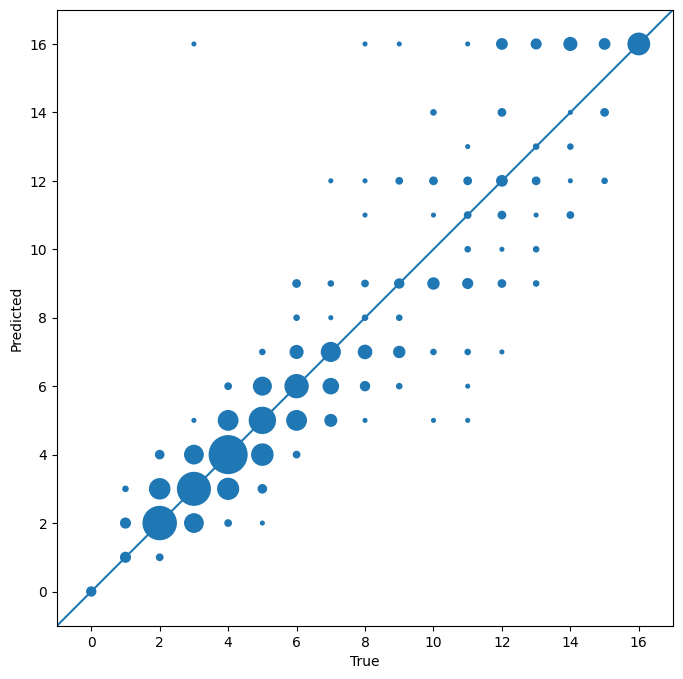

In [ ]:
#Prediction VS Truth
import matplotlib.pyplot as plt

# Combine x_data and y_data into a single 2D array
data_points = np.column_stack((truth, predictions))

# Calculate unique data points and their counts
unique_points, counts = np.unique(data_points, axis=0, return_counts=True)

# Extract x and y coordinates and circle sizes
circle_x, circle_y = unique_points[:, 0], unique_points[:, 1]
circle_sizes = counts * 7

plt.figure(figsize=(8,8))
a = plt.axes(aspect='equal')
plt.scatter(circle_x, circle_y, s = circle_sizes)

plt.xlabel('True')
plt.ylabel('Predicted')
lims = [-1, 17]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

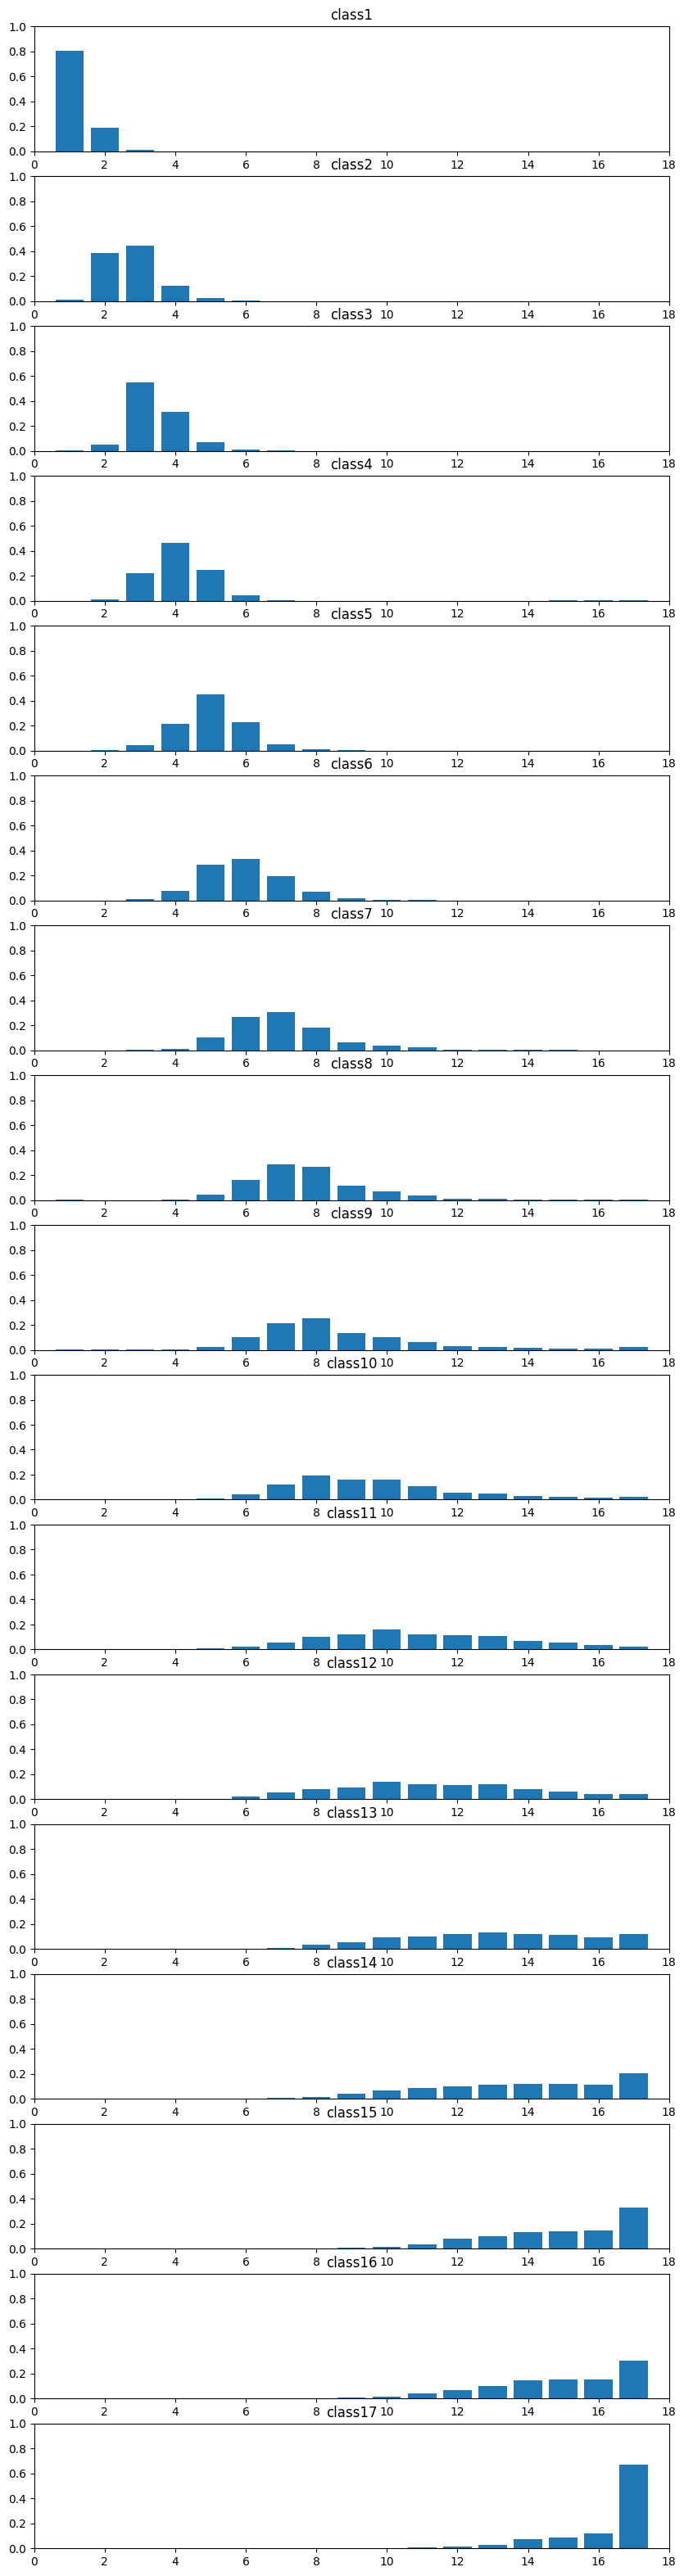

In [ ]:
#Output distribution
import numpy as np
from scipy.special import softmax

output_probability = pd.read_csv("/kaggle/working/output.csv", header = None)
output_probability = output_probability.iloc[:, :-1]
output_probability = output_probability.apply(softmax, axis = 1)
output_distribution = []
plt.figure(figsize = (10, 40))
for i in range(17):
    index = np.where(truth == i)
    class_predict = output_probability.values[index]
    distribution = np.sum(class_predict, axis = 0) / class_predict.shape[0]
    output_distribution.append(distribution)
    plt.subplot(17, 1, i + 1)
    plt.bar(np.linspace(1, 17, 17), distribution)
    plt.ylim(0, 1)
    plt.xlim(-0, 18)
    plt.title(f"class{i+1}")
output_distribution = np.array(output_distribution)

In [ ]:
#output expectation
output_probability = pd.read_csv("/kaggle/working/output.csv", header = None)
output_probability = output_probability.iloc[:, :-1]
output_probability = output_probability.apply(softmax, axis = 1)
output_probability = output_probability.values
age_index = np.arange(1, 18).reshape((17, 1))
age_index = np.array(age_index, dtype = float)
age_index[16] = 19.8
output_exp = output_probability @ age_index
print(output_exp.shape)

(909, 1)


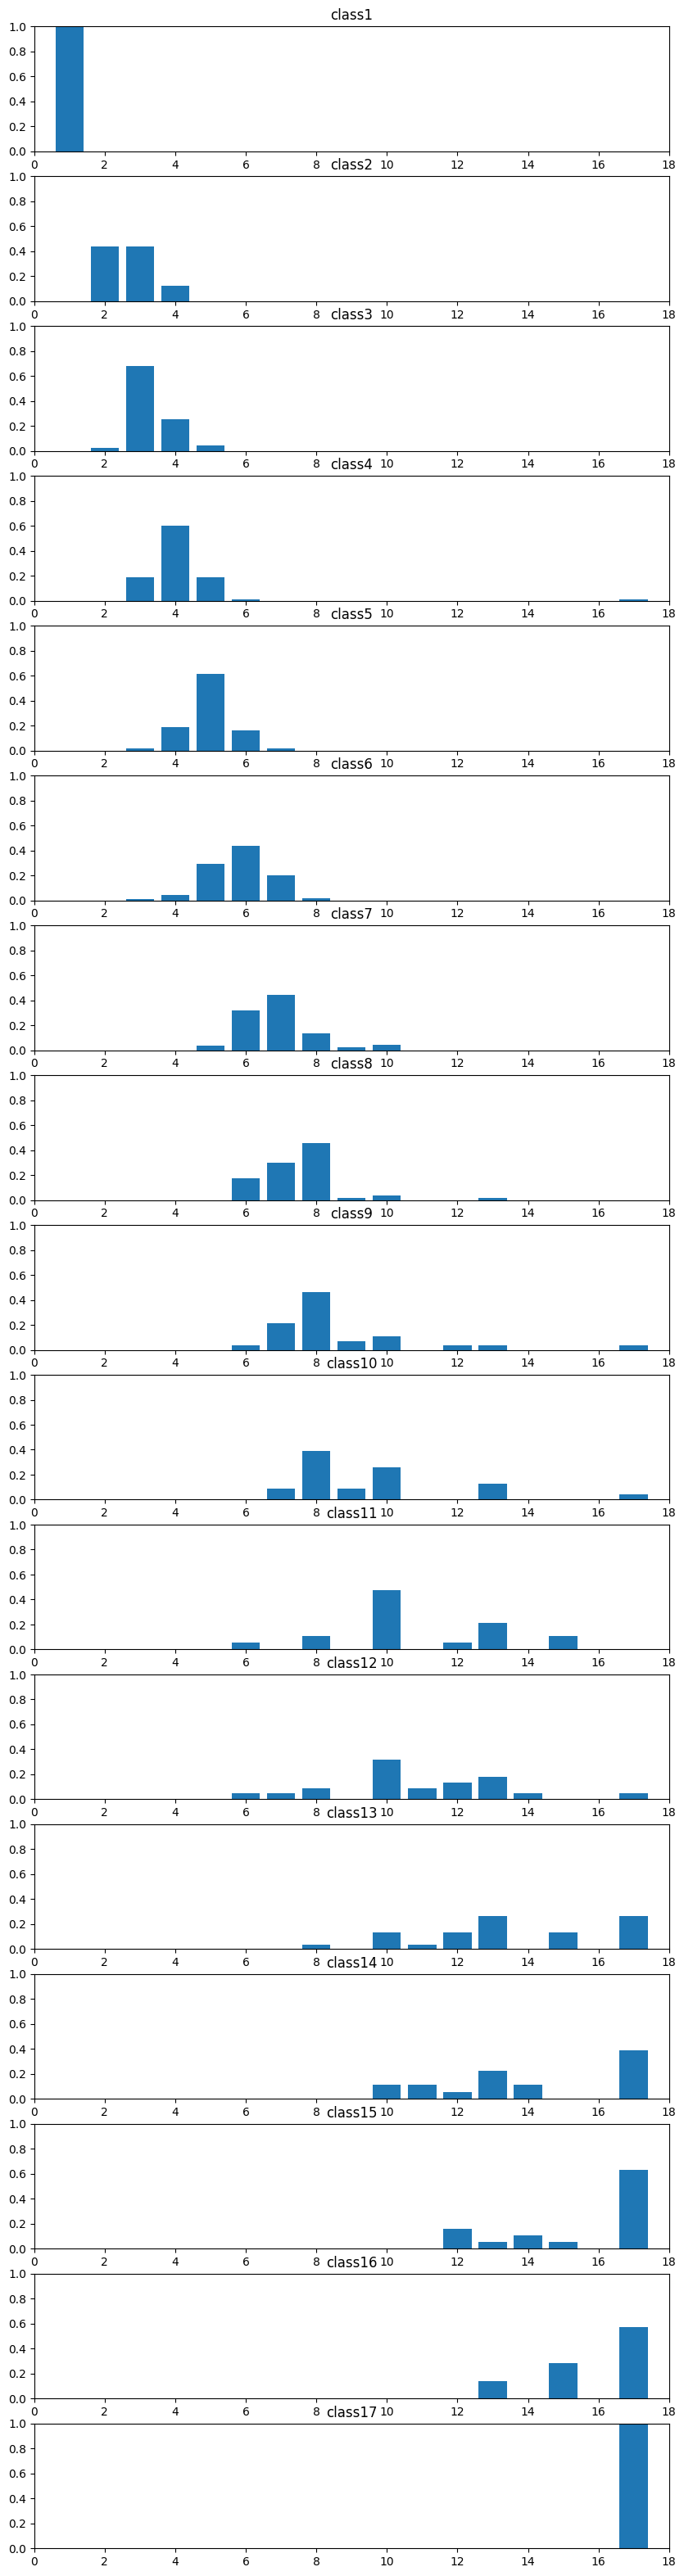

In [ ]:
#Class distribution
class_distribution = []
class_statistics = np.zeros((17, 2))
plt.figure(figsize = (10, 40))
for i in range(17):
    index = np.where(truth == i)
    class_predict = predictions[index]
    class_predict = class_predict.astype(int)
    class_statistics[i, 0] = np.mean(class_predict)
    class_statistics[i, 1] = np.std(class_predict)
    class_counts = np.bincount(class_predict, minlength = 17)
    class_counts = class_counts / sum(class_counts)
    class_distribution.append(class_counts)
    plt.subplot(17, 1, i + 1)
    plt.bar(np.linspace(1, 17, 17), class_counts)
    plt.ylim(0, 1)
    plt.xlim(0, 18)
    plt.title(f"class{i+1}")
#plt.savefig("filename.png")
class_distribution = np.array(class_distribution)

In [ ]:
class_ex = []
for i in range(17):
    distribution = class_distribution[i, :]
    ex = 0
    for j in range(17):
        ex += (j + 1) * distribution[j]
    class_ex.append(ex)
print(class_ex)

[1.0, 2.6875, 3.310924369747899, 4.114503816793893, 4.976608187134502, 5.833333333333334, 6.931818181818182, 7.526315789473684, 8.642857142857142, 9.56521739130435, 10.842105263157896, 10.90909090909091, 13.566666666666666, 14.055555555555555, 15.578947368421051, 15.857142857142856, 17.0]


output expectation r2 score: 0.9008430360305199
0.9923896667886644


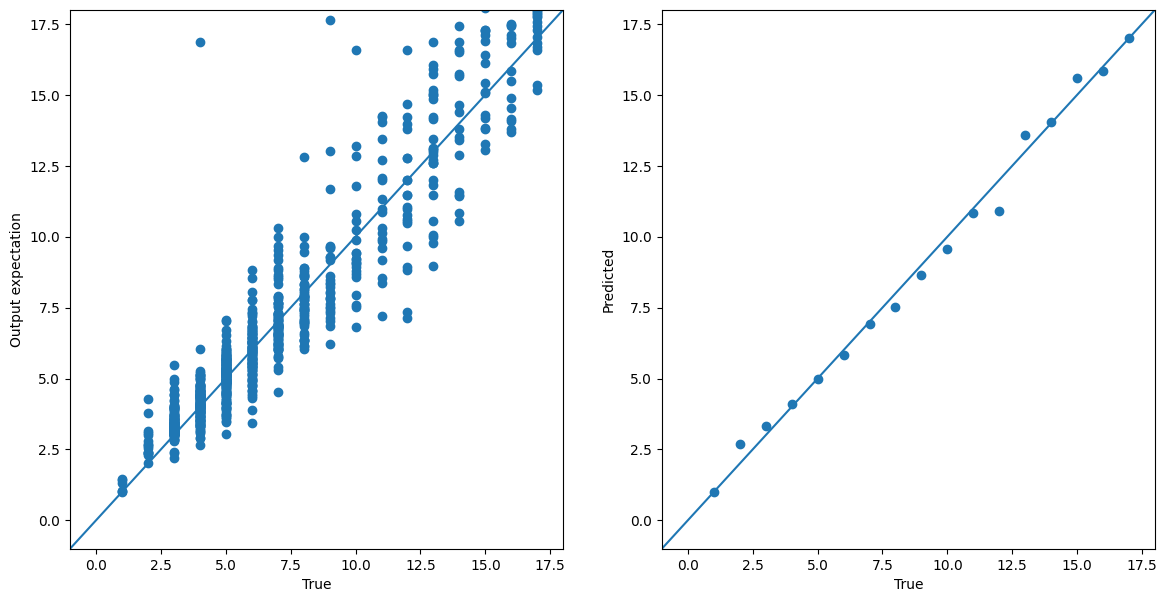

In [ ]:
from sklearn.metrics import r2_score
label_age = np.linspace(1, 17, 17)
output_r2 = r2_score(output_exp, truth + 1)
class_r2 = r2_score(class_ex, label_age)
print(f"output expectation r2 score: {output_r2}")
print(class_r2)
plt.figure(figsize = (14, 7))

plt.subplot(121)
plt.scatter(truth + 1, output_exp)
plt.xlabel('True')
plt.ylabel('Output expectation')
lims = [-1, 18]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.subplot(122)
plt.scatter(label_age, class_ex)
plt.xlabel('True')
plt.ylabel('Predicted')
lims = [-1, 18]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
arr = []
pred1 = []
pred2 = []
pred3 = []
for i in range(17):
    index = np.where(truth == i)
    class_predict = predictions[index]
    class_predict2 = predictions2[index]
    bias = np.sum(class_predict - i * np.ones(class_predict.shape[0]))
    arr.append(bias / class_predict.shape[0])
    accuracy = np.sum(class_predict == i * np.ones(class_predict.shape[0])) / class_predict.shape[0]
    tolerant_accuracy = np.sum(abs(class_predict - i * np.ones(class_predict.shape[0])) <= 1) / class_predict.shape[0]
    top2_accuracy = np.sum(np.array([i in row for row in class_predict2])) / class_predict.shape[0]
    pred1.append(accuracy)
    pred2.append(top2_accuracy)
    pred3.append(tolerant_accuracy)
    print(f"class: {i + 1}, accuracy: {accuracy.round(3)}, top2_accuracy: {top2_accuracy.round(3)}, tolerant_accuracy: {tolerant_accuracy.round(3)}, bias: {bias}")
print(f"total_accuracy: {(np.sum(predictions == truth) / predictions.shape[0])}, total_bias: {np.sum(predictions - truth)}")

class: 1, accuracy: 1.0, top2_accuracy: 1.0, tolerant_accuracy: 1.0, bias: 0.0
class: 2, accuracy: 0.438, top2_accuracy: 0.75, tolerant_accuracy: 0.875, bias: 11.0
class: 3, accuracy: 0.681, top2_accuracy: 0.891, tolerant_accuracy: 0.958, bias: 37.0
class: 4, accuracy: 0.603, top2_accuracy: 0.916, tolerant_accuracy: 0.985, bias: 15.0
class: 5, accuracy: 0.614, top2_accuracy: 0.889, tolerant_accuracy: 0.965, bias: -4.0
class: 6, accuracy: 0.439, top2_accuracy: 0.754, tolerant_accuracy: 0.93, bias: -19.0
class: 7, accuracy: 0.443, top2_accuracy: 0.739, tolerant_accuracy: 0.898, bias: -6.0
class: 8, accuracy: 0.456, top2_accuracy: 0.667, tolerant_accuracy: 0.772, bias: -27.0
class: 9, accuracy: 0.071, top2_accuracy: 0.286, tolerant_accuracy: 0.643, bias: -10.0
class: 10, accuracy: 0.261, top2_accuracy: 0.304, tolerant_accuracy: 0.348, bias: -10.0
class: 11, accuracy: 0.0, top2_accuracy: 0.158, tolerant_accuracy: 0.526, bias: -3.0
class: 12, accuracy: 0.136, top2_accuracy: 0.227, tolerant_

Text(0.5, 1.0, 'Top1_Accuracy')

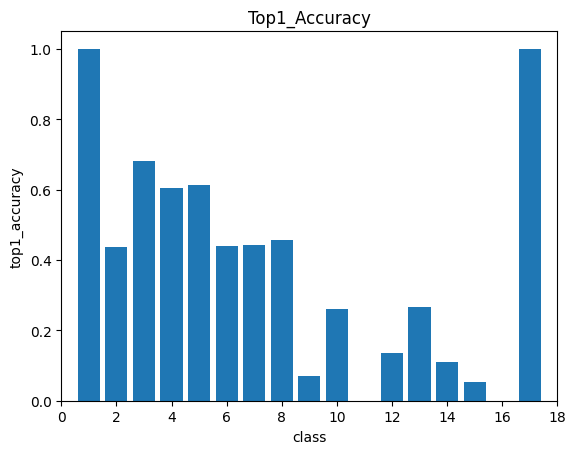

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred1)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("top1_accuracy")
plt.title("Top1_Accuracy")

Text(0.5, 1.0, 'Top2_Accuracy')

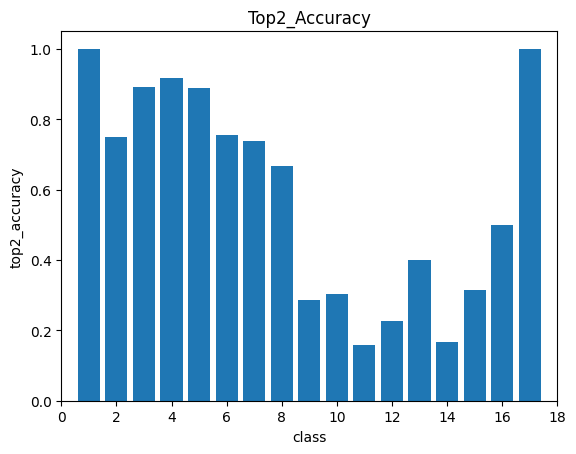

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred2)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("top2_accuracy")
plt.title("Top2_Accuracy")

Text(0.5, 1.0, 'Tolerant_Accuracy')

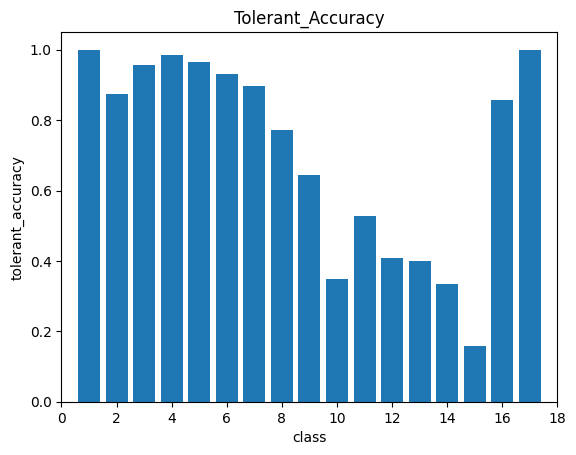

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred3)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("tolerant_accuracy")
plt.title("Tolerant_Accuracy")

Absolute bias: 5.229608721872213


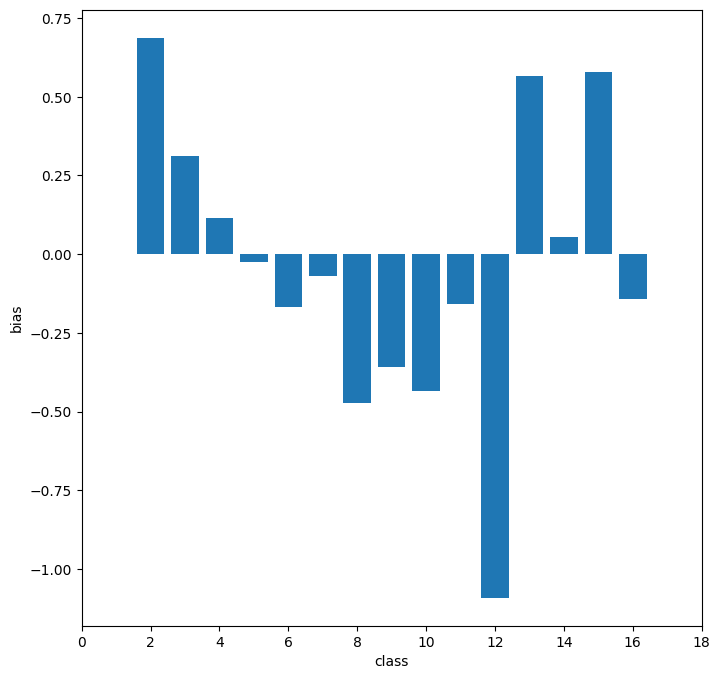

In [ ]:
plt.figure(figsize=(8, 8))
plt.bar(np.linspace(1, 17, 17), arr)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("bias")
print(f"Absolute bias: {sum(np.abs(arr))}")

In [ ]:
arr_2 = []
arr2 = []
pred1_2 = []
pred2_2 = []
pred3_2 = []
for i in range(17):
    index = np.where(truth == i)
    class_predict = output_exp[index] - 1
    class_predict = class_predict[:, 0]
    rounded_predict = np.round(output_exp[index]) - 1
    rounded_predict = rounded_predict[:, 0]
    bias = np.sum(class_predict - i * np.ones(class_predict.shape[0]))
    rounded_bias = np.sum(rounded_predict - i * np.ones(class_predict.shape[0]))
    arr_2.append(bias / class_predict.shape[0])
    arr2.append(rounded_bias / class_predict.shape[0])
    accuracy = np.sum(rounded_predict == i * np.ones(class_predict.shape[0])) / class_predict.shape[0]
    rounded_tolerant_accuracy = np.sum(abs(rounded_predict - i * np.ones(class_predict.shape[0])) <= 1) / class_predict.shape[0]
    tolerant_accuracy = np.sum(abs(class_predict - i * np.ones(class_predict.shape[0])) <= 1) / class_predict.shape[0]
    pred1_2.append(accuracy)
    pred2_2.append(tolerant_accuracy)
    pred3_2.append(rounded_tolerant_accuracy)
    print(f"class: {i + 1}, rounded_accuracy: {accuracy.round(3)}, tolerant_accuracy: {tolerant_accuracy.round(3)}, rounded_tolerant_accuracy: {rounded_tolerant_accuracy.round(3)}, bias: {bias.round(3)}, rounded_bias: {rounded_bias}")
rounded_predict = np.round(output_exp) - 1
rounded_predict = rounded_predict[:, 0]
print(f"total_rounded_accuracy: {(np.sum(rounded_predict == truth) / rounded_predict.shape[0])}, total_bias: {np.sum(output_exp[:, 0] - 1 - truth)}, total_rounded_bias: {np.sum(rounded_predict - truth)}")

class: 1, rounded_accuracy: 1.0, tolerant_accuracy: 1.0, rounded_tolerant_accuracy: 1.0, bias: 1.303, rounded_bias: 0.0
class: 2, rounded_accuracy: 0.375, tolerant_accuracy: 0.75, rounded_tolerant_accuracy: 0.875, bias: 12.391, rounded_bias: 12.0
class: 3, rounded_accuracy: 0.639, tolerant_accuracy: 0.891, rounded_tolerant_accuracy: 0.958, bias: 53.031, rounded_bias: 42.0
class: 4, rounded_accuracy: 0.611, tolerant_accuracy: 0.901, rounded_tolerant_accuracy: 0.985, bias: 27.084, rounded_bias: 24.0
class: 5, rounded_accuracy: 0.573, tolerant_accuracy: 0.865, rounded_tolerant_accuracy: 0.965, bias: 11.866, rounded_bias: 11.0
class: 6, rounded_accuracy: 0.474, tolerant_accuracy: 0.746, rounded_tolerant_accuracy: 0.912, bias: -5.617, rounded_bias: -5.0
class: 7, rounded_accuracy: 0.466, tolerant_accuracy: 0.784, rounded_tolerant_accuracy: 0.841, bias: 3.746, rounded_bias: 9.0
class: 8, rounded_accuracy: 0.351, tolerant_accuracy: 0.719, rounded_tolerant_accuracy: 0.825, bias: -14.055, round

Text(0.5, 1.0, 'Rounded Top1_Accuracy')

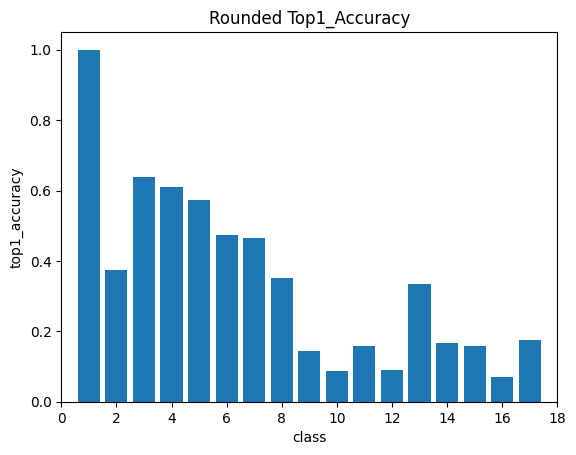

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred1_2)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("top1_accuracy")
plt.title("Rounded Top1_Accuracy")

Text(0.5, 1.0, 'Rounded Top2_Accuracy')

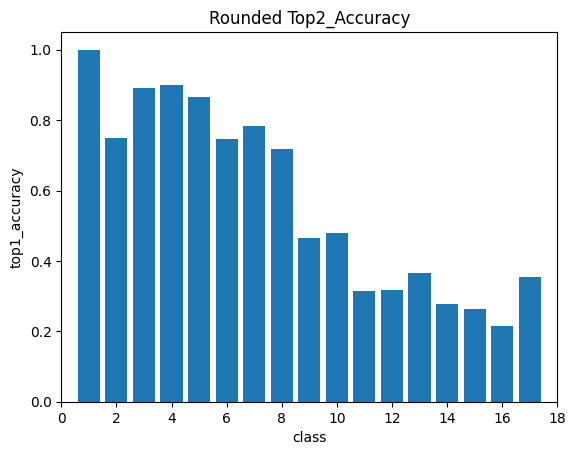

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred2_2)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("top1_accuracy")
plt.title("Rounded Top2_Accuracy")

Text(0.5, 1.0, 'Rounded Tolerant_Accuracy')

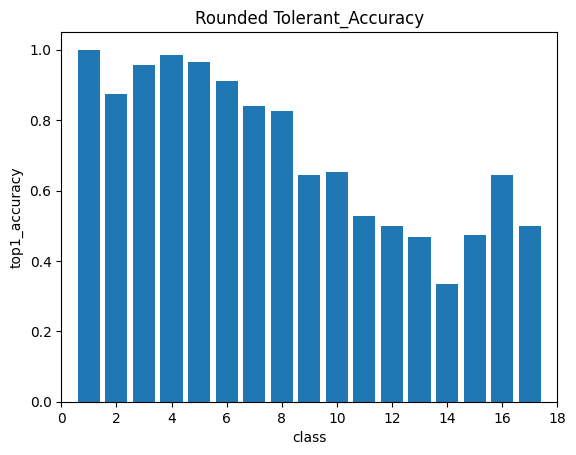

In [ ]:
plt.figure()
plt.bar(np.linspace(1, 17, 17), pred3_2)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("top1_accuracy")
plt.title("Rounded Tolerant_Accuracy")

Absolute bias: 5.882010639881538


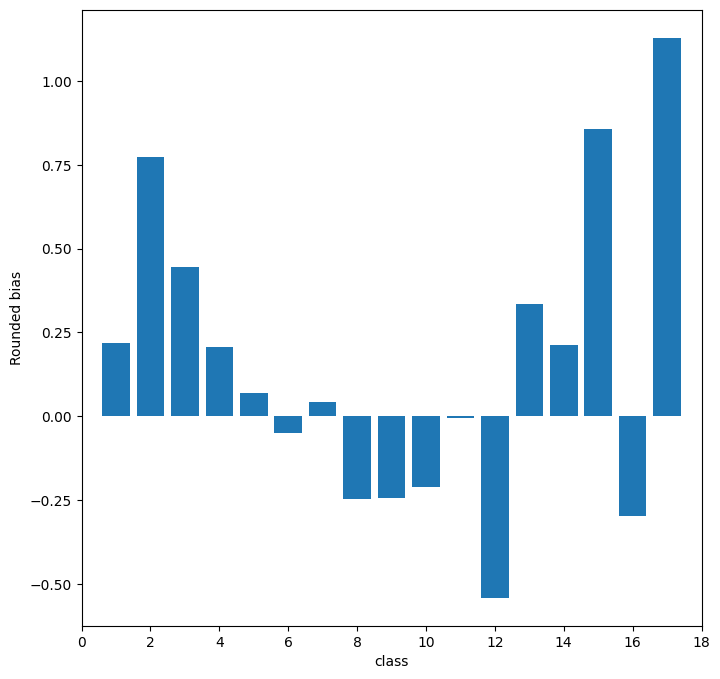

In [ ]:
plt.figure(figsize=(8, 8))
plt.bar(np.linspace(1, 17, 17), arr_2)
plt.xlim(-0, 18)
plt.xlabel("class")
plt.ylabel("Rounded bias")
print(f"Absolute bias: {sum(np.abs(arr_2))}")

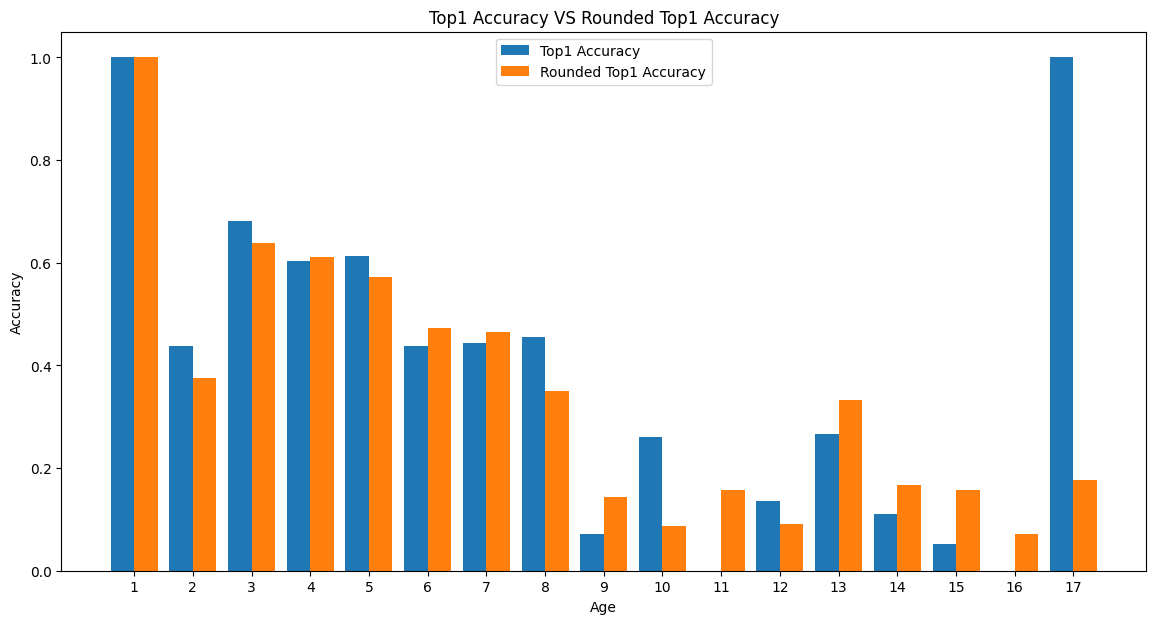

In [ ]:
# plt.figure()
# plt.bar(np.linspace(1, 17, 17), pred1)
# plt.xlim(-0, 18)
# plt.xlabel("class")
# plt.ylabel("accuracy")
plt.figure(figsize = (14, 7))
X = np.arange(1, 18, 1)
bar1 = pred1
bar2 = pred1_2

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, bar1, 0.4, label = 'Top1 Accuracy')
plt.bar(X_axis + 0.2, bar2, 0.4, label = 'Rounded Top1 Accuracy')

plt.xticks(X_axis, X)
plt.xlabel("Age")
plt.ylabel("Accuracy")
plt.title("Top1 Accuracy VS Rounded Top1 Accuracy")
plt.legend()
plt.show()


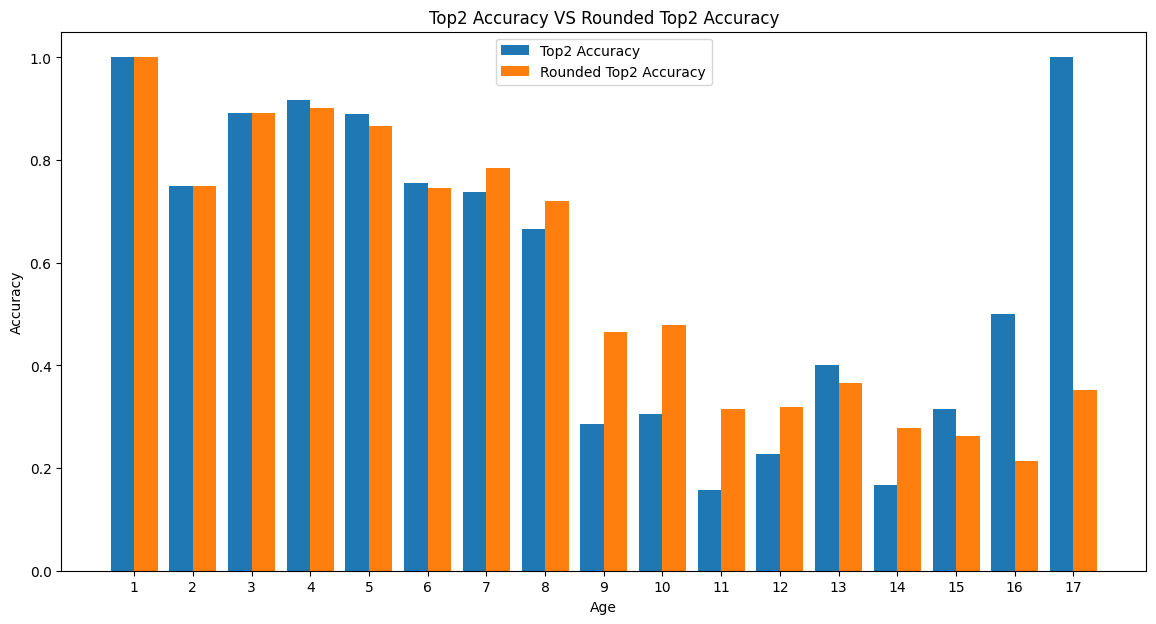

In [ ]:
# plt.figure()
# plt.bar(np.linspace(1, 17, 17), pred1)
# plt.xlim(-0, 18)
# plt.xlabel("class")
# plt.ylabel("accuracy")
plt.figure(figsize = (14, 7))
X = np.arange(1, 18, 1)
bar1 = pred2
bar2 = pred2_2

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, bar1, 0.4, label = 'Top2 Accuracy')
plt.bar(X_axis + 0.2, bar2, 0.4, label = 'Rounded Top2 Accuracy')

plt.xticks(X_axis, X)
plt.xlabel("Age")
plt.ylabel("Accuracy")
plt.title("Top2 Accuracy VS Rounded Top2 Accuracy")
plt.legend()
plt.show()


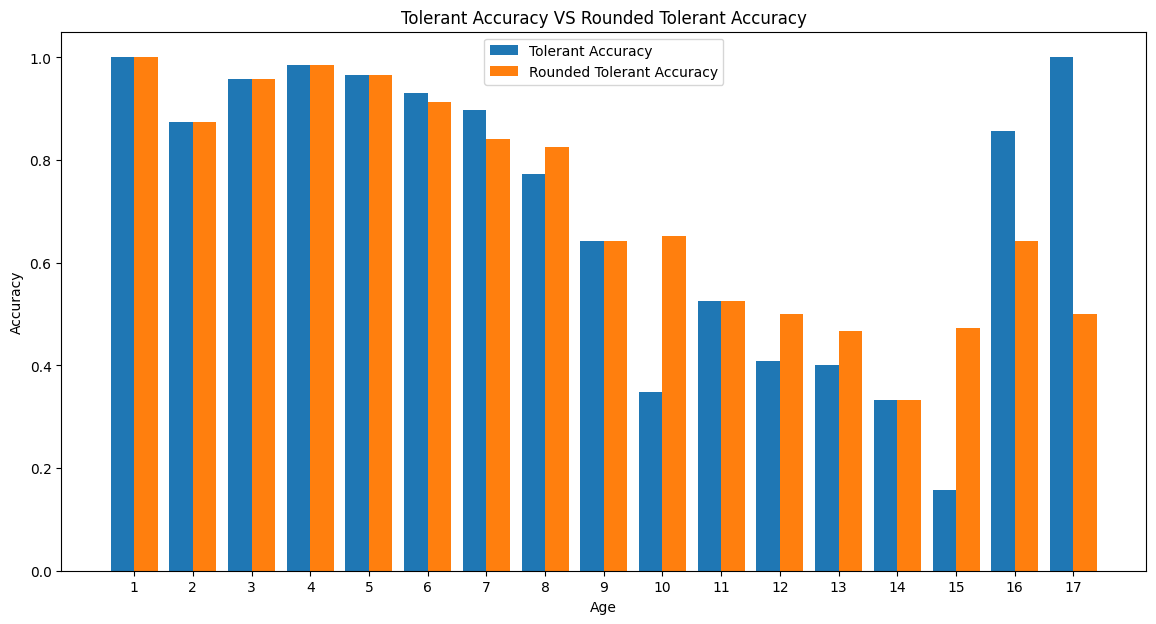

In [ ]:
# plt.figure()
# plt.bar(np.linspace(1, 17, 17), pred1)
# plt.xlim(-0, 18)
# plt.xlabel("class")
# plt.ylabel("accuracy")
plt.figure(figsize = (14, 7))
X = np.arange(1, 18, 1)
bar1 = pred3
bar2 = pred3_2

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, bar1, 0.4, label = 'Tolerant Accuracy')
plt.bar(X_axis + 0.2, bar2, 0.4, label = 'Rounded Tolerant Accuracy')

plt.xticks(X_axis, X)
plt.xlabel("Age")
plt.ylabel("Accuracy")
plt.title("Tolerant Accuracy VS Rounded Tolerant Accuracy")
plt.legend()
plt.show()


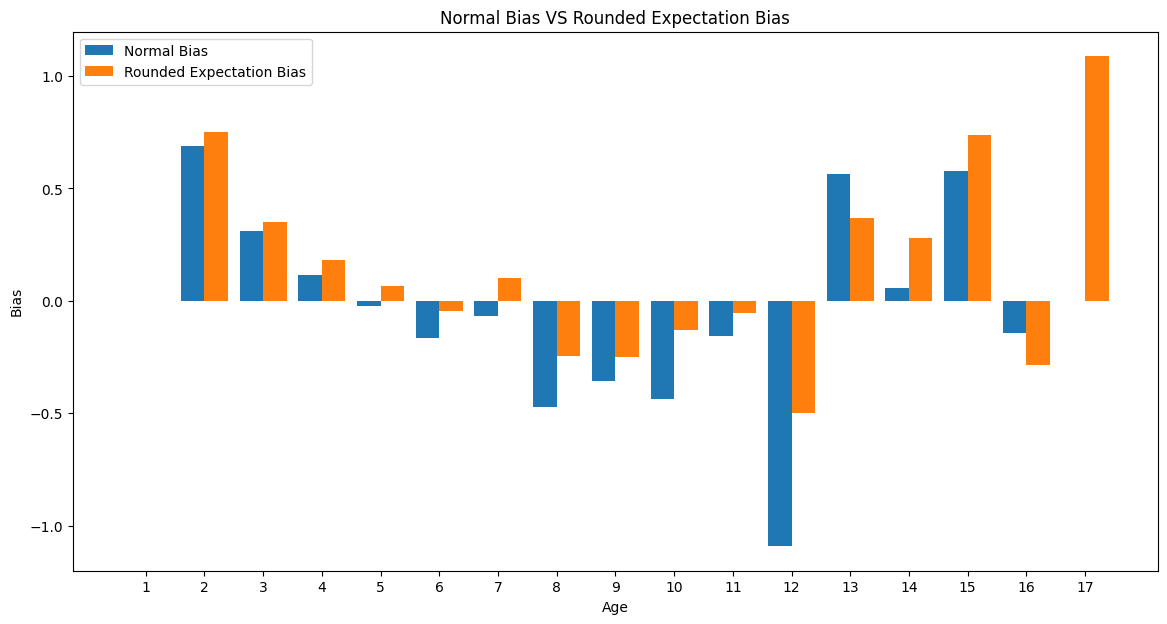

In [ ]:
plt.figure(figsize = (14, 7))
X = np.arange(1, 18, 1)
bar1 = arr
bar2 = arr2

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, bar1, 0.4, label = 'Normal Bias')
plt.bar(X_axis + 0.2, bar2, 0.4, label = 'Rounded Expectation Bias')

plt.xticks(X_axis, X)
plt.xlabel("Age")
plt.ylabel("Bias")
plt.title("Normal Bias VS Rounded Expectation Bias")
plt.legend()
plt.show()
